# CANCER PREDICTION ON IMAGES  


In this kernel I used next kernels 
* [Baseline Keras CNN](https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb)
* [CNN with Keras](https://www.kaggle.com/sdelecourt/cnn-with-keras)

In [0]:
#from tqdm import tqdm_notebook,trange
from numpy.random import seed
from glob import glob #for finding matching filenames

import os #for working with operating system
import cv2 #for image processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import Keras NN
import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


In [0]:
# Look at the dataframe and count the number of positive and negative samples
df_train = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

print(df_train.head())
df_train['label'].value_counts()

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


0    130908
1     89117
Name: label, dtype: int64

In [0]:
#path = "../input/histopathologic-cancer-detection/" #adapt this path, when running locally
train_path = "../input/histopathologic-cancer-detection/train/"
test_path = "../input/histopathologic-cancer-detection/test/"\

# Create the new column "path" which point the path to tif. images
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames
df['id'] = df.path.map(lambda x: x.split('/')[4].split(".")[0]) # keep only the file names in 'id'
df = df.merge(df_train, on = "id") # merge labels and filepaths
df.head()

,path,id,label
0,../input/histopathologic-cancer-detection/trai...,92d05227eaa5198211a0402a7a7e840c3e55c4cb,0
1,../input/histopathologic-cancer-detection/trai...,1964c4fc2a7ababd9e7b657fa77b9cf26047b6fa,0
2,../input/histopathologic-cancer-detection/trai...,250425c10dfb5260c0875904a304a1e3a335022e,0
3,../input/histopathologic-cancer-detection/trai...,e2e51830174f815b383c6852596605262c6153e8,0
4,../input/histopathologic-cancer-detection/trai...,79797c9230db4af8493cab611bc0b327e07eda66,1


In [0]:
df['label'] = df['label'].astype('str')

# Visualization of cancer images


In [0]:
# Function to show the images via path
def readImage(path):
    bgr_img = cv2.imread(path)
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

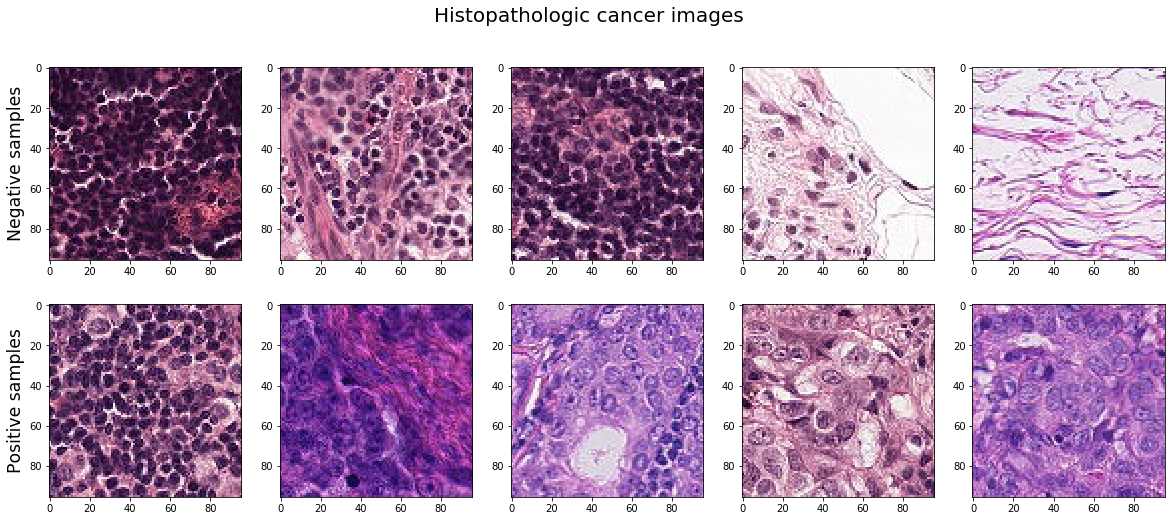

In [0]:
# Shuffle data to watch cancer images
shuffled_data = shuffle(df_train)

# Creation the plot box for negative and positive images
fig, ax = plt.subplots(2,5,figsize=(20,8))
fig.suptitle('Histopathologic cancer images',fontsize=20)

# Negative cancer samples 
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0, i].imshow(readImage(path + '.tif'))
ax[0,0].set_ylabel('Negative samples', size='xx-large')   

# Positive cancer samples
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1, i].imshow(readImage(path + '.tif'))    
ax[1,0].set_ylabel('Positive samples', size='xx-large')   
plt.show()

# Data augmentation, data preprocessing

It hepls in case of *overfitting*.
In *Keras* data augmentation can be done via ImageDataGenerator with regulated transformation and normalization functions. Here I use some of them, like *rescale*. We multiply the *rescale* value to decrease the RGB coefficients 0-255.
Then we use *flow_from_dataframe* function to build train and valid generators

In [0]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(df,test_size=0.2)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
# Train generator using train_valid data split (with split coef = 0.2)
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train,
    x_col='path', #column in dataframe contains the filenames
    y_col='label', #columnn in df contains target value
    batch_size=32,#size of the batches of data
    class_mode='binary',#mode for yielding the targets
    target_size=(96,96)) #the dimensions to which all images found will be resized.



Found 176020 validated image filenames belonging to 2 classes.


In [0]:
# Validation generator using train_valid data split (with split coef = 0.2)
validation_generator = train_datagen.flow_from_dataframe(
                dataframe=valid,
                x_col = 'path',
                y_col = 'label',
                target_size=(96, 96),
                batch_size=32,
                class_mode='binary'
                )

Found 44005 validated image filenames belonging to 2 classes.


# The architecture of Neural Network

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam

IMAGE_SIZE = 96 #the dimensionality of an image
kernel_size = (3,3) #the height and width of the 2D convolution window
pool_size= (2,2) #factors by which to downscale (vertical, horizontal)
first_filters = 32 #the dimensionality of the output space
second_filters = 64 #the dimensionality of the output space
third_filters = 128 #the dimensionality of the output space

dropout_conv = 0.3 #fraction of the input units to drop
dropout_dense = 0.5 ##fraction of the input units to drop
# Create linear stack of layers.
model = Sequential() 

#First block
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, use_bias=False)) #No use a bias vector (default=True)
model.add(BatchNormalization()) #Normalize the activations of the previous layer at each batch
model.add(Activation("relu")) #Rectified Linear Unit activation function
model.add(MaxPool2D(pool_size = pool_size)) #Max pooling operation for spatial data.
model.add(Dropout(dropout_conv)) #randomly select neurons and ignore
#Second block
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))
#Third block
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = "sigmoid"))

# Compile the model 
model.compile(Adam(learning_rate=0.01), loss = "binary_crossentropy", metrics=["accuracy"])


In [0]:
num_train_samples = len(train)
num_val_samples = len(valid)
train_batch_size = 32
val_batch_size = 32

#Defining the number of train and validation steps
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

# Keras callbacks and fit_generator
EarlyStopping and ReduceLROnPlateau are used
1. **EarlyStopping** stops training when a **val_loss** has stopped improving.
    * **val_loss** - the value of cost function for cross-validation data
    * **patience ** - number of epochs that produced the **val_loss** with no improvement after which training will be stopped  
    * **restore_best_weights ** - use the best epoch weights if True 
2. **ReduceLROnPlateau** - reduce learning rate when a metric has stopped improving. 
    * **factor** - factor by which the learning rate (lr) will be reduced. new_lr = lr * factor


In [0]:
#filepath = "model.h5"
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

#fit_generator with calculated number of steps and generators
history = model.fit_generator(train_generator, steps_per_epoch=train_steps, 
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    epochs=10,
                   callbacks=[reducel, earlystopper])


Epoch 1/10
5501/5501 [==============================] - 284s 52ms/step - loss: 0.2805 - accuracy: 0.8868 - val_loss: 0.6657 - val_accuracy: 0.8865
Epoch 2/10
5501/5501 [==============================] - 283s 51ms/step - loss: 0.2721 - accuracy: 0.8918 - val_loss: 0.2809 - val_accuracy: 0.8932
Epoch 3/10
5501/5501 [==============================] - 282s 51ms/step - loss: 0.2682 - accuracy: 0.8935 - val_loss: 0.0682 - val_accuracy: 0.8930
Epoch 4/10
5501/5501 [==============================] - 284s 52ms/step - loss: 0.2649 - accuracy: 0.8953 - val_loss: 0.1422 - val_accuracy: 0.8987

Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 5/10
5501/5501 [==============================] - 280s 51ms/step - loss: 0.2635 - accuracy: 0.8954 - val_loss: 0.2527 - val_accuracy: 0.8934

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Restoring model weights from the end of the best epoch
Epoch 00005: early stopping


In [0]:
TEST_BATCH = 64
testing_files = glob(os.path.join('../input/histopathologic-cancer-detection/test/','*.tif'))
submission = pd.DataFrame()

for index in range(0, len(testing_files), TEST_BATCH): #iterate over test image batches
    data_frame = pd.DataFrame({'path': testing_files[index:index+TESTING_BATCH_SIZE]}) #add the filenames to the dataframe
    data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[4].split(".")[0]) #add the ids to the dataframe
    data_frame['image'] = data_frame['path'].map(imread) #read the batch
    images = np.stack(data_frame.image, axis=0) #convert to numpy array
    predicted_labels = [model.predict(np.expand_dims(image/255.0, axis=0))[0][0] for image in images]
    predictions = np.array(predicted_labels)
    data_frame['label'] = predictions
    submission = pd.concat([submission, data_frame[["id", "label"]]])

In [0]:
submission.to_csv("result.csv", index = False, header = True)
submission.head()

,id,label
0,fd517274998cfd379a09efe30844712da2ed9f11,0.019732
1,e1f4b3f7492f88f0c85fcbfbc54583eb7b084b5c,0.631442
2,8513ed4c78bde5b3e07ab8adccfb2d5533706b64,0.010750
3,b9c668f45424de28fe02f34da9868650270e2d6c,0.998354
4,44ca9f5a77f4a7be6a0da7ae3278d72bc5bc04a1,0.992878


# Conclusion

I used **tensorflow.Keras** API for modelling the prediction of cancer on images as in the above mentioned kernels. I applied some data augmentation and dropout technique in model

In result I obtained the best LB score - 0.93
